## **pyTopoComplexity (v0.7.3)**
### **Example for using `pyrugosity` module to calculate rugosity index** 

Fractal dimension analysis provides a powerful method for characterizing the roughness and complexity of land surfaces using Digital Elevation Model (DEM) data. This approach, as implemented in the `pyfracd` module, offers a quantitative measure of terrain texture at various scales. For each cell in the DEM, the local fractal dimension is calculated using the intersection of the surface within the moving window with four vertical planes corresponding to the principal geographical directions (N-S, E-W, NW-SE, and NE-SW). This reduces the problem to estimating the fractal dimension of one-dimensional topographic profiles. The variogram method is used to estimate the fractal dimension of these profiles. The variogram, a statistical function that estimates the dissimilarity between two random variables separated by a distance, is particularly effective for this purpose. The relationship between the variogram and distance is modeled using a power-law function, from which the fractal dimension can be derived.

The pyfracd class implements this methodology, providing not only the local fractal dimension estimates but also reliability parameters such as the standard error of the estimated fractal dimension and the coefficient of determination. These additional metrics help assess the quality and reliability of the fractal dimension estimates across the analyzed terrain.

To use this code, please cite the Zenodo repository that hosts the latest release of this code: 
* Lai, L. S.-H. (2024). pyTopoComplexity. Zenodo. https://doi.org/10.5281/zenodo.11239338
* Github repository: https://github.com/GeoLarryLai/pyTopoComlexity
<hr>

### **Theory**

Rugosity measures the complexity of the surface texture and is defined as the ratio of the actual surface area to the planar area. It is calculated using a $N \times N$ neighborhood around each pixel:

$$
\text{Rugosity Index} = \frac{\text{real surface area}}{\text{planimetric area}}
$$
<hr>

### **References**
##### Journal Articles: 
* Jenness, J.S. (2004), Calculating landscape surface area from digital elevation models. Wildlife Society Bulletin, 32: 829-839. https://doi.org/10.2193/0091-7648(2004)032[0829:CLSAFD]2.0.CO;2
* Wilson, M.F.J., O’Connell, B., Brown, C., Guinan, J.C., Grehan, A.J., 2007. Multiscale Terrain Analysis of Multibeam Bathymetry Data for Habitat Mapping on the Continental Slope. Marine Geodesy 30, 3-35. https://doi.org/10.1080/01490410701295962 
* Du Preez, C. A new arc–chord ratio (ACR) rugosity index for quantifying three-dimensional landscape structural complexity. Landscape Ecol 30, 181–192 (2015). https://doi.org/10.1007/s10980-014-0118-8

##### Digital Elevation Model (DEM) Examples:
* Washington Geological Survey, 2023. 'Stillaguamish 2014' and 'Snohoco Hazel 2006' projects [lidar data]: originally contracted by Washington State Department of Transportation (WSDOT). [accessed April 4, 2024, at http://lidarportal.dnr.wa.gov]
<hr>

#### 1. Import raster

In [1]:
import os

# File handling
base_dir = os.getcwd()  # Change the directory of base folder as needed
base_dir = os.path.join(base_dir, 'ExampleDEM')
input_file = 'Ososlid2014_f_3ftgrid.tif'
input_dir = os.path.join(base_dir, input_file)

#### 2. Run pyrugosity analysis

In [2]:
from pytopocomplexity import pyrugosity

# Create an instance of pyrugosity
rgty = pyrugosity(chunk_processing=True, chunksize=(512, 512))

# Run analysis using pyrugosity module
Z, result, meta, window_m = rgty.analyze(input_dir, window_size = 17)
#window_size must be an odd number and >= 3 (default is set to 3)
#returned 'window_m' will always be in meters, calculated from defined 'window_size' and the grid spacing of the input raster

[########################################] | 100% Completed | 5.92 sms


#### 3. Export results

In [3]:
# Generate output file name
output_file = os.path.splitext(input_file)[0] + f'_pyRugosity({round(window_m, 2)}m).tif'
output_dir = os.path.join(base_dir, output_file)

# Export the result using pyrugosity module
rgty.export_result(result, meta, output_dir)

Processed result saved to Ososlid2014_f_3ftgrid_pyRugosity(15.54m).tif


#### 4. Display results

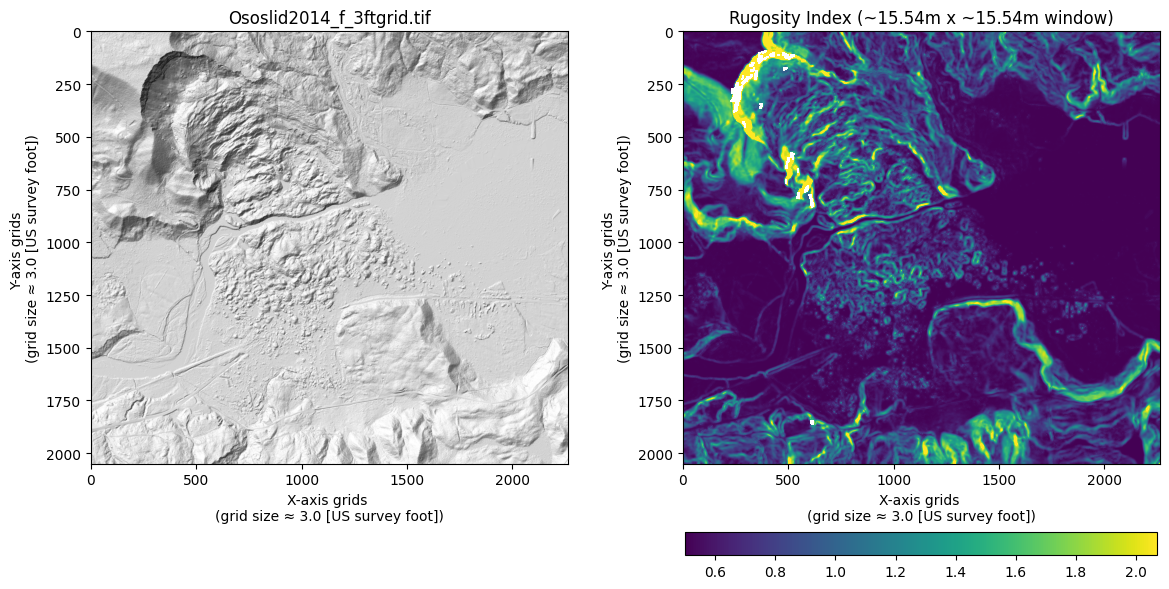

In [4]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource

# Get CRS information for plotting
with rasterio.open(input_dir) as src:
    transform = src.transform
    crs = src.crs

# Plot results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot the hillshade
ls = LightSource(azdeg=315, altdeg=45)
hs = axes[0].imshow(ls.hillshade(Z, vert_exag=2), cmap='gray')
axes[0].set_title(input_file)
axes[0].set_xlabel(f'X-axis grids \n(grid size ≈ {round(transform[0],4)} [{crs.linear_units}])')
axes[0].set_ylabel(f'Y-axis grids \n(grid size ≈ {-round(transform[4],4)} [{crs.linear_units}])')
cbar1 = fig.colorbar(hs, ax=axes[0], orientation='horizontal', fraction=0.045, pad=0.13)
cbar1.ax.set_visible(False)

# Plot the 2D-CWT roughness
im = axes[1].imshow(result, cmap='viridis')
im.set_clim(round(np.nanpercentile(result, 1), 2), round(np.nanpercentile(result, 99), 2))
axes[1].set_title(f'Rugosity Index (~{round(window_m, 2)}m x ~{round(window_m, 2)}m window)')
axes[1].set_xlabel(f'X-axis grids \n(grid size ≈ {round(transform[0],4)} [{crs.linear_units}])')
axes[1].set_ylabel(f'Y-axis grids \n(grid size ≈ {-round(transform[4],4)} [{crs.linear_units}])')
cbar2 = fig.colorbar(im, ax=axes[1], orientation='horizontal', fraction=0.045, pad=0.13)

plt.tight_layout()
plt.savefig('pyrugosity.png', dpi=200, bbox_inches='tight')
plt.show()